In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json

# Definições iniciais

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


def make_init_cond(x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var):
    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=size_t,
        endpoint=True,
    )

    print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

    print(
        "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
            size_t,
            size_x,
            size_y,
        )
    )

    return size_x, size_y, size_t, initial_cond


size_x, size_y, size_t, initial_cond = make_init_cond(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var
)

Size x = 20, y = 20 
 
Steps in time = 1786
Steps in space_x = 20
Steps in space_y = 20



In [3]:
struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)

print("struct_name: ", struct_name)

struct_name:  h--0.05__k--0.0056__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


# Archtecture handling

In [4]:
with open("fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cb_fdm = pk.load(f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cn_fdm = pk.load(f)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


xx, tt, yy = np.meshgrid(
    x_np,
    t_np,
    y_np,
)

data_input_np = np.array([Cn_fdm.flatten(), Cb_fdm.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t_tc = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    x_tc = (
        torch.tensor(xx, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    y_tc = (
        torch.tensor(yy, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t_tc = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    x_tc = torch.tensor(xx, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y_tc = torch.tensor(yy, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

del xx
del yy
del tt

cuda


In [5]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [6]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [7]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](3, int(out_neurons)))

                else:
                    modules.append(nn.Linear(3, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [8]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


# PINN

In [9]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [10]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [11]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [12]:
def shuffle_data(x, y, z):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return x[Data_num], y[Data_num], z[Data_num]

In [13]:
def train_test_split(x, y, z, test_size=0.5, shuffle=True):
    with torch.no_grad():
        if shuffle:
            x, y, z = shuffle_data(x, y, z)
        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            z_train, z_test = z[:train_ratio], z[train_ratio:]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )
        elif test_size in range(1, len(x)):
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            z_train, z_test = z[test_size:], z[:test_size]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )

In [14]:
def gerenate_training_points(num_points, device):
    x = torch.rand(num_points, 1).to(device)
    y = torch.rand(num_points, 1).to(device)
    t = torch.rand(num_points, 1).to(device) * 10

    return t.requires_grad_(True), x.requires_grad_(True), y.requires_grad_(True)

In [15]:
def gerenate_boundary_points(num_points, device):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        n = torch.tensor([[0.0, -1.0], [0.0, 1.0]]).repeat(num_points // 2, 1)
    else:
        n = torch.tensor([[-1.0, 0.0], [1.0, 0.0]]).repeat(num_points // 2, 1)

    return (
        x_boundary.to(device).requires_grad_(True).view(-1, 1),
        y_boundary.to(device).requires_grad_(True).view(-1, 1),
        n.to(device),
    )

In [16]:
def initial_condition(x, y):

    Cl = torch.full_like(x, 0)

    Cp = torch.full_like(x, 0)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.6)) and ((yy >= 0.5) and (yy <= 0.6)):
            Cp[i] = 0.2

    return torch.cat([Cl, Cp], dim=1)

In [17]:
def boundary_condition(t_b, x_b, y_b, n, model, Dn, X_nb, Db):

    input_data = torch.cat([t_b, x_b, y_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    nx, ny = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx
        )

        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny
        )

        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [18]:
def pde(model, t, x, y, cb, lambd_nb, Db, y_n, Cn_max, lambd_bn, mi_n, Dn, X_nb):

    Cl, Cp = model(torch.cat([t, x, y], dim=1)).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cb * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (Cn_max - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [19]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        device,
        data_input,
        t,
        x,
        y,
        n_points,
        constant_properties,
        norm_weights=None,
        validation=None,
        tolerance=None,
        patience=10,
    ):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.model = model.to(device)
        self.device = device
        self.data_input = data_input
        self.t = t
        self.x = x
        self.y = y
        self.n_points = n_points
        self.constant_properties = constant_properties
        self.norm_weights = norm_weights
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience
        pass

    def loss_func(
        self,
    ):
        # Computing intial loss
        t_initial = torch.zeros_like(self.train_t[self.i : self.i + self.batch_size])

        mesh_ini = torch.cat(
            [
                t_initial,
                self.train_x[self.i : self.i + self.batch_size],
                self.train_y[self.i : self.i + self.batch_size],
            ],
            dim=1,
        )

        C_initial_pred = model(mesh_ini)

        self.loss_initial = self.criterium(
            self.C_initial[self.i : self.i + self.batch_size], C_initial_pred
        )

        # Computing pde loss

        x_pde, y_pde, t_pde = gerenate_training_points(self.n_points, device)

        predicted_pde = pde(
            model,
            t_pde,
            x_pde,
            y_pde,
            self.constant_properties["cb"],
            self.constant_properties["lambd_nb"],
            self.constant_properties["Db"],
            self.constant_properties["y_n"],
            self.constant_properties["Cn_max"],
            self.constant_properties["lambd_bn"],
            self.constant_properties["mi_n"],
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
        )

        self.loss_pde = self.criterium(
            predicted_pde,
            torch.zeros_like(predicted_pde),
        )

        # Computing boundary loss

        x_bnd, y_bnd, n_bnd = gerenate_boundary_points(self.n_points, device)

        predicted_boundary = boundary_condition(
            t_pde,
            x_bnd,
            y_bnd,
            n_bnd,
            model,
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.constant_properties["Db"],
        )

        self.loss_boundary = self.criterium(
            predicted_boundary,
            torch.zeros_like(predicted_boundary),
        )

        # Computing data loss

        C_pred = model(self.train_data_input[self.i : self.i + self.batch_size])

        self.loss_data = self.criterium(
            self.train_data[self.i : self.i + self.batch_size], C_pred
        )

        self.loss = (
            10 * self.loss_initial
            + self.loss_pde
            + self.loss_boundary
            + self.loss_data * 10
        )

        self.loss.backward()

        return self.loss

    def execute(
        self,
    ):
        self.criterium = nn.MSELoss()

        dt_min, dt_max = self.norm_weights if self.norm_weights else (0, 1)

        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )

        if self.validation:
            (
                self.train_data,
                self.test_data,
                self.train_t,
                self.test_t,
                train_dom,
                test_dom,
            ) = train_test_split(
                self.data_input,
                self.t,
                torch.cat([self.x, self.y], dim=1),
                test_size=self.validation,
            )
            self.train_x, self.train_y = train_dom.split(1, dim=1)
            self.test_x, self.test_y = test_dom.split(1, dim=1)
            self.train_data_input = torch.cat(
                [self.train_t, self.train_x, self.train_y], dim=1
            )
            self.test_data_input = torch.cat(
                [self.test_t, self.test_x, self.test_y], dim=1
            )

        else:
            self.train_data = data_input
            self.test_data_input = None
            self.train_t = self.t
            self.test_t = None
            self.train_x = self.x
            self.test_x = None
            self.train_y = self.y
            self.test_y = None
            self.test_data = None
            self.train_data_input = torch.cat(
                [self.t, self.train_x, self.train_y], dim=1
            )

        C_pde_loss_it = torch.zeros(self.n_epochs).to(device)
        C_data_loss_it = torch.zeros(self.n_epochs).to(device)
        C_boundary_loss_it = torch.zeros(self.n_epochs).to(device)
        C_initial_loss_it = torch.zeros(self.n_epochs).to(device)
        self.C_initial = initial_condition(self.train_x, self.train_y).to(device)
        val_loss_it = torch.zeros(self.n_epochs).to(device)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for self.i in range(0, len(self.train_t), self.batch_size):

                self.optimizer.zero_grad()

                self.optimizer.step(self.loss_func)
                self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss
                    val_loss = self.criterium(
                        self.test_data, model(self.test_data_input)
                    )

            C_pde_loss_it[epoch] = self.loss_pde.item()
            C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 100) == 0 or (epoch == 0):
                print(
                    f"Finished epoch {epoch+1}, latest loss {self.loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {self.loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

# Training

In [21]:
decay_rate = 0.9985
n_epochs = 600
batch_size = 71440

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    device=device,
    data_input=data_input,
    x=x_tc,
    y=y_tc,
    t=t_tc,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=0.1,
    tolerance=0.001,
    patience=60,
)

In [22]:
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()

KeyboardInterrupt: 

# Validation

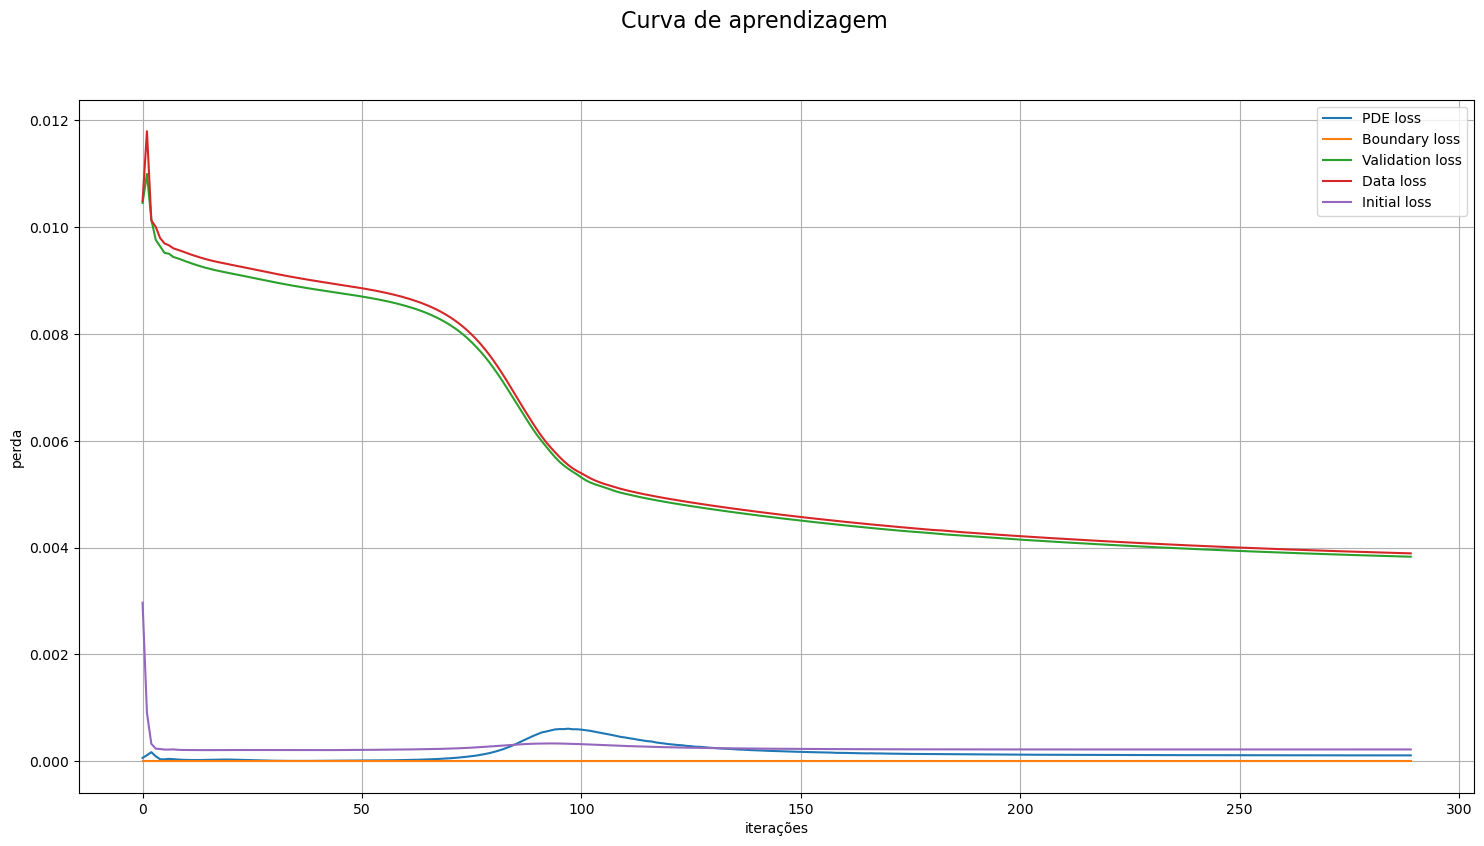

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_boundary_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

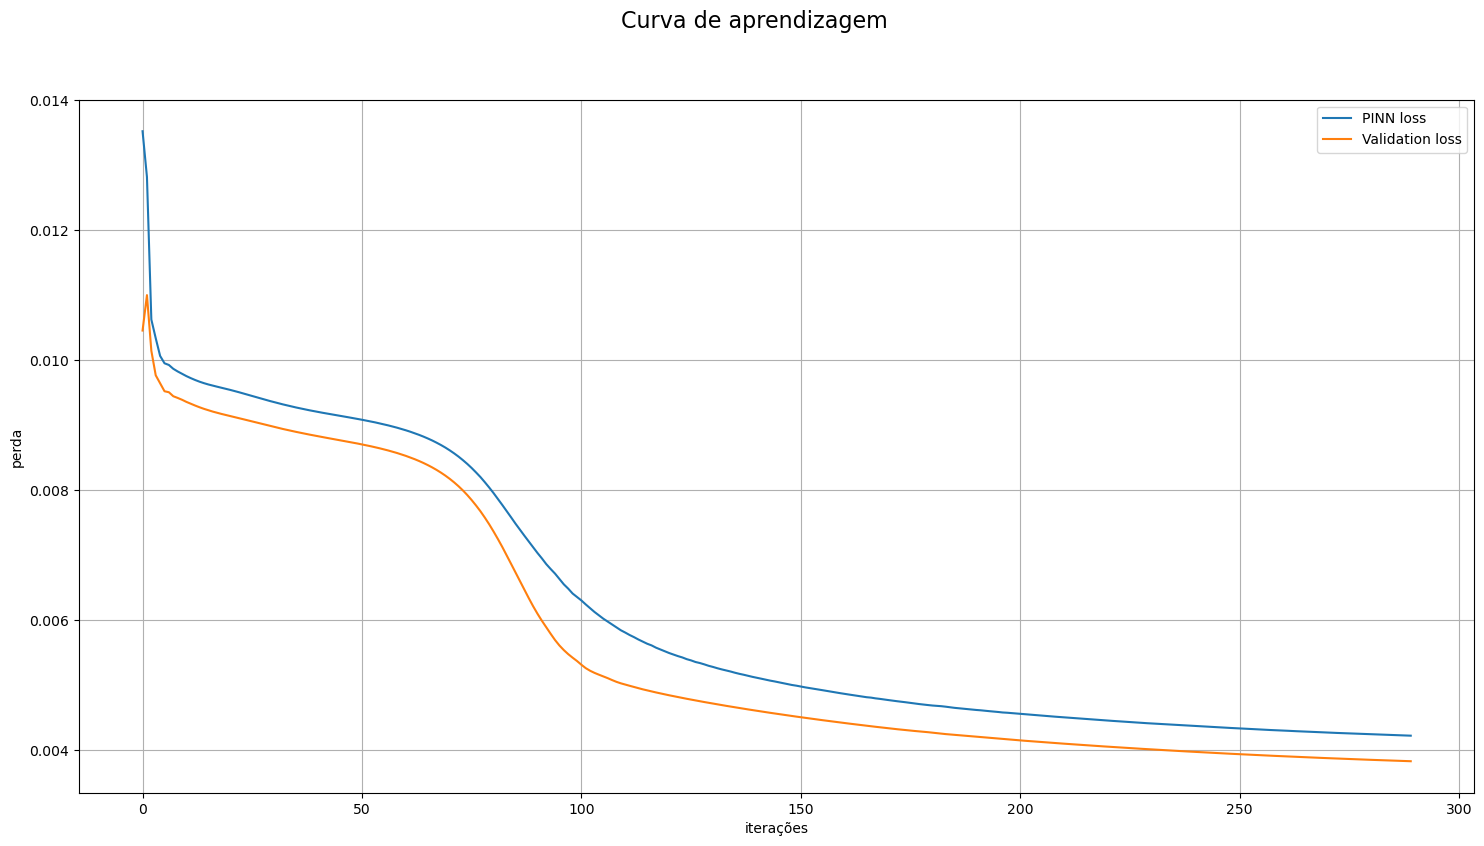

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

# Saving model weights and biases

In [25]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([32, 3])
0.bias 	 torch.Size([32])
2.weight 	 torch.Size([32, 32])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([32, 32])
4.bias 	 torch.Size([32])
6.weight 	 torch.Size([32, 32])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [26]:
import os

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + arch_str + ".pt")

In [9]:
import os

cwd = os.getcwd()

model = generate_model(arch_str).to(device)

model.load_state_dict(
    torch.load(cwd + "/nn_parameters/" + arch_str + ".pt", weights_only=True)
)

model.eval()

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [10]:
from fvm_model_parallel import cu_solve_pde
import math
from numba import cuda

speed_up = []

for i in range(33):

    start = time.time()

    # Definindo número de threads e blocos para cuda

    threadsperblock = (size_x, size_y)
    blockspergrid_x = math.ceil(size_x / threadsperblock[0])
    blockspergrid_y = math.ceil(size_y / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)

    Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
    Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))

    # This extra array is used for synchronization purposes

    Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
    Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
    Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

    cu_solve_pde[threadsperblock, blockspergrid](
        Cb_buf_0,
        Cn_buf_0,
        Cb_buf_1,
        Cn_buf_1,
        Cb_final_device,
        Cn_final_device,
        size_t,
        size_x,
        size_y,
        h,
        k,
        Db,
        Dn,
        phi,
        cb,
        lambd_nb,
        mi_n,
        lambd_bn,
        y_n,
        Cn_max,
        X_nb,
    )

    Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
    Cb_final_device.copy_to_host(Cb_host)

    Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
    Cn_final_device.copy_to_host(Cn_host)

    end = time.time()

    cuda_time = end - start

    start = time.time()

    mesh = torch.cat([t_tc, x_tc, y_tc], dim=1)

    with torch.no_grad():
        Cl_pinn_device, Cp_pinn_device = model(mesh).split(1, dim=1)

    Cl_pinn = Cl_pinn_device.cpu().detach().numpy()
    Cp_pinn = Cp_pinn_device.cpu().detach().numpy()

    end = time.time()

    pinn_time = end - start

    speed_up.append(cuda_time / pinn_time)

In [11]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

In [12]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [13]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.06358706988974742
Erro absoluto máximo 0.4003769376868218
Speed Up: 2.349835967519717 +/-2.9866154858201006


In [14]:
speed_up

[19.23052511663231,
 1.8644763249832752,
 1.9066304412376032,
 2.0904085154235417,
 1.816220510939983,
 1.6292220113851992,
 1.9536836693159665,
 1.7403660886319845,
 1.9713056264325564,
 1.70382127455678,
 1.9529067737430168,
 1.860559474778779,
 1.9195564123112911,
 2.0075258496575192,
 1.6982644354237428,
 1.7951182982857374,
 1.7782529887375003,
 1.815558723165306,
 1.6658653356422533,
 1.7929957569622434,
 1.589815533400991,
 1.8165211665498417,
 1.9141984470112494,
 1.8040691012086225,
 1.6275508250698725,
 1.9089883496409432,
 1.86578425454859,
 1.5716387678666972,
 1.9577740127720578,
 1.8378937049823125,
 1.9261967374339897,
 1.7537748902123564,
 1.7771175092065619]

In [15]:
Cl_pinn_np = Cl_pinn.reshape(size_t, size_x, size_y)
Cp_pinn_np = Cp_pinn.reshape(size_t, size_x, size_y)

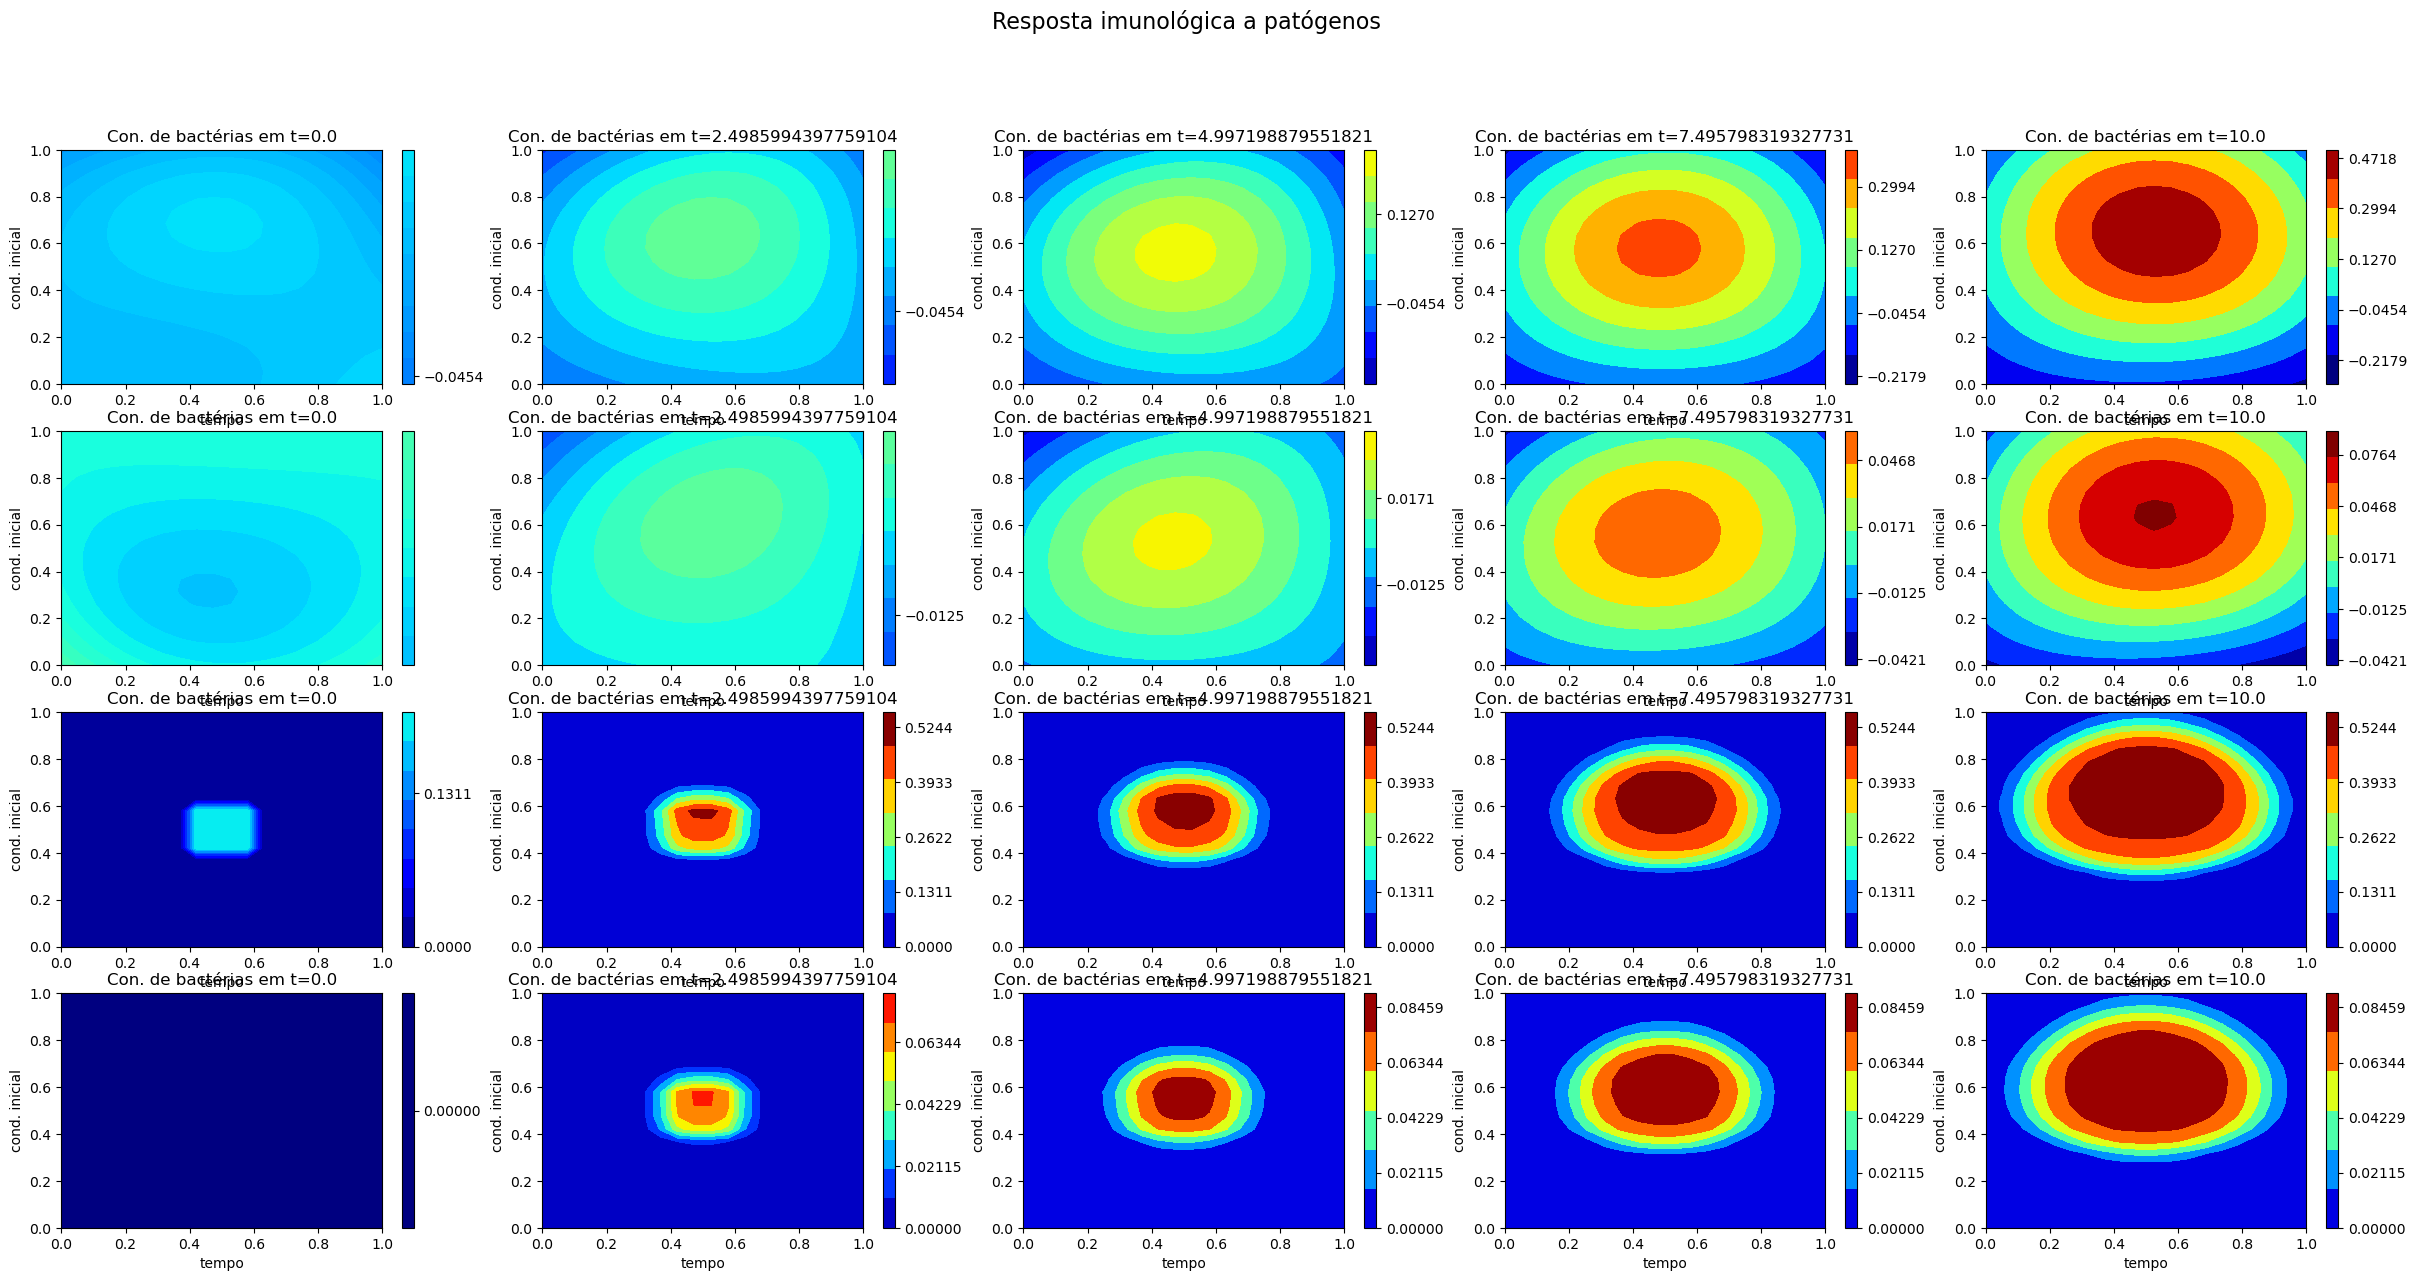

In [18]:
x = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=True)
t = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=True)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cb_fdm)
    vmax = np.max(Cb_fdm)

    contour = ax.contourf(
        X,
        Y,
        Cb_fdm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cn_fdm)
    vmax = np.max(Cn_fdm)

    contour = ax.contourf(
        X,
        Y,
        Cn_fdm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()